In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.parallel
from tqdm import tqdm 
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import torchvision as torchvision


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from zipfile import ZipFile

zip_path = "/content/drive/MyDrive/GAN_Faces_data/faces.zip"
path_to_unzip = "/content/drive/MyDrive/GAN_Faces_data"

# loading the temp.zip and creating a zip object
with ZipFile(zip_path, 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(path_to_unzip)

In [3]:
train_dir = "/content/drive/MyDrive/GAN_faces_data/faces/train/"

In [4]:
# Defining the hyper-parameters 

# Batch Size for the dataset
BATCH_SIZE = 128

# setting image sizes for our dataset 
# normally 178*218 however we will reduce it to 64 for the sake of trainning
IMG_SIZE = 64

# setting the number of epochs
EPOCH_NUMBER = 20

# setting the learning rate 
lr = 0.0002

#interval to train generator
critic_iter = 2

#clipping parameter
weight_clip = 0.01


In [5]:
#transforms for training data
transform=transforms.Compose([
                               transforms.Resize(IMG_SIZE),
                               transforms.CenterCrop(IMG_SIZE),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

In [8]:
train_dataset = dset.ImageFolder(root=train_dir,transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True,drop_last=True)

In [3]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

<class 'list'>


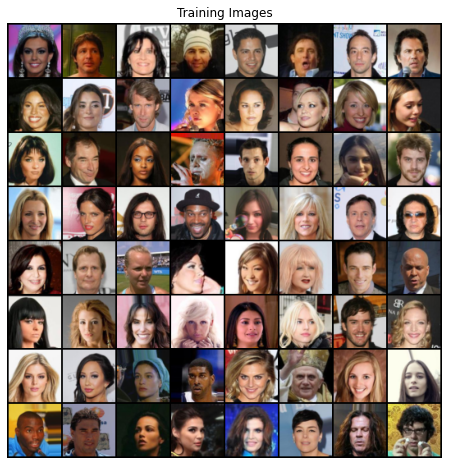

In [10]:
#showing some examles of training batch
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
print(type(real_batch))
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
class Generator(nn.Module):
    def __init__(self) -> None:
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #input 100 * 1024 * 3

            nn.ConvTranspose2d(100, 1024, kernel_size= 4, stride= 2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.ReLU(True),

         
            nn.ConvTranspose2d(1024, 512, kernel_size= 4, stride=2,padding= 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            
            nn.ConvTranspose2d(512, 256, kernel_size= 4, stride=2,padding= 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            
            nn.ConvTranspose2d(256, 128, kernel_size= 4, stride=2,padding= 1,bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, 64, kernel_size= 4, stride=2,padding= 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, kernel_size= 4, stride=2,padding= 1, bias=False),
            nn.Tanh()
            )

    def forward(self, input):
        return self.main(input)

In [12]:
class Discriminator(nn.Module):
    def __init__(self) -> None:
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64,  kernel_size= 4, stride=2,padding= 1, bias=True),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2,  kernel_size= 4, stride=2,padding= 1, bias=True),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, kernel_size= 4, stride=2,padding= 1, bias=True),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8,  kernel_size= 4, stride=2,padding= 1, bias=True),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 128,  kernel_size= 4, stride=1,padding= 0, bias=True),
            nn.Flatten(),
            nn.Linear(128, 1)
        )

    def forward(self, input):
        return self.main(input)

In [5]:
# Create an instance of generator 
gen_net = Generator().to(device)

# Handle multi-gpu 
if (device.type == 'cuda'):
    gen_net = nn.DataParallel(gen_net, [0])

print(gen_net)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)


In [14]:
# Create the Discriminator
dis_net = Discriminator().to(device)

# Handle multi-gpu 
if (device.type == 'cuda'):
    dis_net = nn.DataParallel(dis_net, [0])

print(dis_net)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 128, kernel_size=(4, 4), stride=(1, 1))
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [19]:
#initiate RMS optimizer
dis_optimizer = optim.RMSprop(dis_net.parameters(), lr=lr)
gen_optimizer = optim.RMSprop(gen_net.parameters(), lr=lr)

In [16]:
from torchvision.utils import make_grid
import imageio

to_image = transforms.ToPILImage()

Remark:
New loss function derived from the Wasserstein distance

Discriminator tries to maximize the difference between its output on real instances and its output on fake instances.
Generator tries to maximize the discriminator's output for its fake instances.

In [ ]:
path_to_save_training_gif = '/content/drive/MyDrive/GAN_faces_data/progress.gif'
path_to_save_images = '/content/drive/MyDrive/GAN_faces_data/saved_faces/'
path_gen_net_dict = '/content/drive/MyDrive/GAN_faces_data/models/gen_net_dict.pth'
path_dis_net_dict = '/content/drive/MyDrive/GAN_faces_data/models/dis_net_dict.pth'
path_full_gen_net = '/content/drive/MyDrive/GAN_faces_data/models/full_gen_net.pt'
path_full_dis_net = '/content/drive/MyDrive/GAN_faces_data/models/full_dis_net.pt'

In [ ]:
g_losses = []
c_losses = []
images = []
fake_images_for_grid = []
test_noise =  torch.randn(1, 100, 1, 1, device=device)


#iteration over the epochs
for epoch in tqdm(range(EPOCH_NUMBER)):
  #iteration over batches
  for i, (imgs, _ ) in tqdm(enumerate(train_loader)):
    imgs = imgs.to(device)
    noise = torch.randn(BATCH_SIZE, 100, 1, 1, device=device)
    fake_data = gen_net(noise).detach()
    dis_optimizer.zero_grad()
    loss_real = dis_net(imgs).mean()
    loss_fake = dis_net(fake_data).mean()
    # - (D(x) - D(G(z)))
    dis_loss = -(loss_real - loss_fake)
    dis_loss.backward()
    dis_optimizer.step()
    # Clip weights of discriminator
    for p in dis_net.parameters():
        p.data.clamp_(-weight_clip, weight_clip)

    # Train the generator every n_critic iterations
    if (i+1) % critic_iter == 0:
            fake_data = gen_net(noise)
            gen_optimizer.zero_grad()
            # D(G(z))
            gen_loss = -dis_net(fake_data).mean()  
            gen_loss.backward()
            gen_optimizer.step()
            g_losses.append(gen_loss)
            c_losses.append(dis_loss)
            img = gen_net(test_noise).cpu().detach()
            img = make_grid(img)
            images.append(to_image(img))
            imageio.mimsave(path_to_save_training_gif, [np.array(i) for i in images])  
            print('Epoch {}: G_loss: {:.4f} C_loss: {:.4f}'.format(epoch, gen_loss, dis_loss))
            #final output for trained model
            if epoch == EPOCH_NUMBER-1 : 
              with torch.no_grad():
                fake_images = gen_net(torch.randn(20, 100, 1, 1, device=device))
                fake_images_for_grid.append(vutils.make_grid(fake_images, padding=2, normalize=True))
              path_to_save = os.path.join(path_to_save_images, "{0:0=6d}_loss.png".format(epoch+1))
              save_image(fake_images_for_grid, path_to_save, nrow=5, normalize=True)


torch.save(gen_net.state_dict(), path_gen_net_dict)
torch.save(gen_net, path_full_gen_net)
torch.save(dis_net, path_full_dis_net)
torch.save(dis_net.state_dict(), path_dis_net_dict)



  0%|          | 0/10 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [01:18, 78.19s/it]
2it [02:34, 77.01s/it]

Epoch 0: G_loss: 0.6129 C_loss: -0.1624



3it [03:51, 76.98s/it]
4it [05:12, 78.64s/it]

Epoch 0: G_loss: 0.4510 C_loss: -0.1769



5it [06:30, 78.29s/it]
6it [07:48, 78.27s/it]

Epoch 0: G_loss: 0.4783 C_loss: -0.1738



7it [09:10, 79.44s/it]
8it [10:29, 79.29s/it]

Epoch 0: G_loss: 0.4316 C_loss: -0.2025



9it [11:46, 78.82s/it]
10it [13:04, 78.54s/it]

Epoch 0: G_loss: 0.5391 C_loss: -0.2874



11it [14:17, 76.74s/it]
12it [15:37, 77.79s/it]

Epoch 0: G_loss: 0.4580 C_loss: -0.3829



13it [16:58, 78.81s/it]
14it [18:20, 79.59s/it]

Epoch 0: G_loss: 0.4801 C_loss: -0.3352



15it [19:39, 79.61s/it]
16it [20:59, 79.68s/it]

Epoch 0: G_loss: 0.5906 C_loss: -0.4343



17it [22:23, 80.82s/it]
18it [23:45, 81.15s/it]

Epoch 0: G_loss: 0.5960 C_loss: -0.7870



19it [25:06, 81.28s/it]
20it [26:28, 81.51s/it]

Epoch 0: G_loss: 0.6297 C_loss: -0.8241



21it [27:48, 81.01s/it]
22it [29:09, 80.98s/it]

Epoch 0: G_loss: 0.3954 C_loss: -0.8186



23it [30:30, 81.07s/it]
24it [31:47, 79.68s/it]

Epoch 0: G_loss: 0.5324 C_loss: -0.4313



25it [33:07, 79.78s/it]
26it [34:26, 79.59s/it]

Epoch 0: G_loss: 0.7030 C_loss: -0.6877



27it [35:51, 81.23s/it]
28it [37:08, 80.00s/it]

Epoch 0: G_loss: 0.7002 C_loss: -0.7649



29it [38:28, 80.04s/it]
30it [39:51, 80.83s/it]

Epoch 0: G_loss: 0.8576 C_loss: -0.8994



31it [41:08, 79.61s/it]
32it [42:31, 80.76s/it]

Epoch 0: G_loss: 0.7163 C_loss: -0.7322



33it [43:53, 80.99s/it]
34it [45:13, 80.83s/it]

Epoch 0: G_loss: 0.8084 C_loss: -0.9600



35it [46:34, 80.84s/it]
36it [47:57, 81.40s/it]

Epoch 0: G_loss: 0.8954 C_loss: -1.1877



37it [49:18, 81.34s/it]
38it [50:40, 81.61s/it]

Epoch 0: G_loss: 0.7627 C_loss: -1.2746



39it [51:58, 80.45s/it]
40it [53:18, 80.30s/it]

Epoch 0: G_loss: 0.7039 C_loss: -1.1451



41it [54:42, 81.48s/it]
42it [56:04, 81.72s/it]

Epoch 0: G_loss: 0.8346 C_loss: -0.6823



43it [57:23, 80.79s/it]
44it [58:40, 79.69s/it]

Epoch 0: G_loss: 0.8589 C_loss: -1.0199



45it [1:00:02, 80.27s/it]
46it [1:01:19, 79.44s/it]

Epoch 0: G_loss: 0.9049 C_loss: -0.6692



47it [1:02:43, 80.66s/it]
48it [1:04:09, 82.31s/it]

Epoch 0: G_loss: 0.8940 C_loss: -1.0555



49it [1:05:30, 82.09s/it]
50it [1:06:49, 81.01s/it]

Epoch 0: G_loss: 0.9403 C_loss: -0.6267



51it [1:08:08, 80.40s/it]
52it [1:09:29, 80.75s/it]

Epoch 0: G_loss: 0.9472 C_loss: -1.0610



53it [1:10:50, 80.81s/it]
54it [1:12:15, 81.94s/it]

Epoch 0: G_loss: 0.8980 C_loss: -1.2164



55it [1:13:36, 81.77s/it]
56it [1:14:56, 81.11s/it]

Epoch 0: G_loss: 0.6180 C_loss: -1.1932



57it [1:16:20, 82.02s/it]
58it [1:17:45, 82.84s/it]

Epoch 0: G_loss: 0.9474 C_loss: -0.9881



59it [1:19:06, 82.45s/it]
60it [1:20:30, 82.88s/it]

Epoch 0: G_loss: 0.9057 C_loss: -0.5970



61it [1:21:53, 82.78s/it]
62it [1:23:16, 83.03s/it]

Epoch 0: G_loss: 0.9791 C_loss: -1.2653



63it [1:24:44, 84.28s/it]
64it [1:26:03, 82.75s/it]

Epoch 0: G_loss: 1.0032 C_loss: -1.0643



65it [1:27:19, 80.90s/it]
66it [1:28:41, 81.15s/it]

Epoch 0: G_loss: 0.8395 C_loss: -0.4915



67it [1:30:07, 82.61s/it]
68it [1:31:26, 81.58s/it]

Epoch 0: G_loss: 0.8175 C_loss: -0.9064



69it [1:32:48, 81.47s/it]
70it [1:34:12, 82.33s/it]

Epoch 0: G_loss: 0.8548 C_loss: -0.7206



71it [1:35:34, 82.36s/it]
72it [1:37:02, 83.91s/it]

Epoch 0: G_loss: 0.7753 C_loss: -0.4639



73it [1:38:23, 82.97s/it]
74it [1:39:45, 82.71s/it]

Epoch 0: G_loss: 0.8654 C_loss: -0.8542



75it [1:41:10, 83.50s/it]
76it [1:42:35, 83.95s/it]

Epoch 0: G_loss: 0.7681 C_loss: -0.8415



77it [1:44:02, 84.84s/it]
78it [1:45:19, 82.44s/it]

Epoch 0: G_loss: 0.9603 C_loss: -0.7096



79it [1:46:42, 82.78s/it]
80it [1:48:03, 82.21s/it]

Epoch 0: G_loss: 0.9981 C_loss: -0.9533



81it [1:49:29, 83.28s/it]
82it [1:50:54, 83.76s/it]

Epoch 0: G_loss: 0.6474 C_loss: -0.5709



83it [1:52:16, 83.26s/it]
84it [1:53:37, 82.68s/it]

Epoch 0: G_loss: 0.1180 C_loss: -0.1846



85it [1:54:58, 82.11s/it]
86it [1:56:24, 83.34s/it]

Epoch 0: G_loss: -0.4987 C_loss: -0.0080



87it [1:57:51, 84.47s/it]
88it [1:59:14, 83.76s/it]

Epoch 0: G_loss: -0.5151 C_loss: -0.0076



89it [2:00:35, 83.08s/it]
90it [2:01:59, 83.27s/it]

Epoch 0: G_loss: -0.5266 C_loss: -0.0026



91it [2:03:25, 84.17s/it]
92it [2:04:52, 85.04s/it]

Epoch 0: G_loss: -0.5001 C_loss: -0.0064



93it [2:06:17, 85.12s/it]
94it [2:07:42, 84.96s/it]

Epoch 0: G_loss: -0.4069 C_loss: -0.0393



95it [2:09:12, 86.40s/it]
96it [2:10:34, 85.30s/it]

Epoch 0: G_loss: -0.4200 C_loss: -0.0454



97it [2:12:01, 85.58s/it]
98it [2:13:22, 84.32s/it]

Epoch 0: G_loss: -0.3940 C_loss: -0.0747



99it [2:14:45, 83.85s/it]
100it [2:16:07, 83.30s/it]

Epoch 0: G_loss: -0.2790 C_loss: -0.1136



101it [2:17:30, 83.10s/it]
102it [2:18:54, 83.51s/it]

Epoch 0: G_loss: -0.1150 C_loss: -0.1707



103it [2:20:19, 83.83s/it]
104it [2:21:43, 84.02s/it]

Epoch 0: G_loss: 0.0207 C_loss: -0.2328



105it [2:23:10, 84.95s/it]
106it [2:24:34, 84.68s/it]

Epoch 0: G_loss: -0.0232 C_loss: -0.2618



107it [2:25:56, 83.92s/it]
108it [2:27:22, 84.48s/it]

Epoch 0: G_loss: 0.0593 C_loss: -0.2070



109it [2:28:40, 82.40s/it]
110it [2:30:06, 83.69s/it]

Epoch 0: G_loss: 0.3304 C_loss: -0.3541



111it [2:31:28, 83.21s/it]
112it [2:33:00, 85.67s/it]

Epoch 0: G_loss: 0.4310 C_loss: -0.4167



113it [2:34:23, 85.06s/it]
114it [2:35:47, 84.73s/it]

Epoch 0: G_loss: 0.6103 C_loss: -0.4741



115it [2:37:06, 83.01s/it]
116it [2:38:30, 83.19s/it]

Epoch 0: G_loss: 0.6848 C_loss: -0.4863



117it [2:39:53, 83.23s/it]
118it [2:41:15, 82.83s/it]

Epoch 0: G_loss: 0.7327 C_loss: -0.6203



119it [2:42:43, 84.41s/it]
120it [2:44:07, 84.09s/it]

Epoch 0: G_loss: 0.8143 C_loss: -0.7398



121it [2:45:32, 84.35s/it]
122it [2:47:09, 88.15s/it]

Epoch 0: G_loss: 0.6972 C_loss: -0.5737



123it [2:48:34, 87.19s/it]
124it [2:50:06, 88.62s/it]

Epoch 0: G_loss: 0.5826 C_loss: -0.9165



125it [2:51:29, 87.08s/it]
126it [2:52:51, 85.63s/it]

Epoch 0: G_loss: 0.4821 C_loss: -0.4959



127it [2:54:10, 83.66s/it]
128it [2:55:31, 82.80s/it]

Epoch 0: G_loss: 0.2919 C_loss: -0.3744



129it [2:56:59, 84.24s/it]
130it [2:58:22, 84.01s/it]

Epoch 0: G_loss: 0.5774 C_loss: -0.2418



131it [2:59:44, 83.30s/it]

In [ ]:
g = [i.tolist() for i in g_losses]
c = [i.tolist() for i in c_losses]

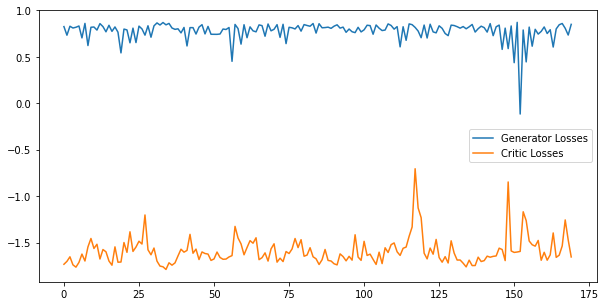

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(g, label='Generator Losses') 
plt.plot(c, label='Critic Losses')
plt.legend()
plt.savefig('loss.png')